# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import math
from reduce_mem_usage import reduce_mem_usage
import glob

# Japanese font setting
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']

from sklearn.linear_model import LogisticRegression
import pickle

# enlarge plot
# plt.rcParams['figure.figsize'] = (20, 7)

# HOUR = 1
HOUR = 24

CLASSIFIER = 'logistic'

TARGET = 'outcome1'
# TARGET = 'dos_within_1d'
# TARGET = 'dos_within_2d'
# TARGET = 'dos_within_3d'
# TARGET = 'dos_within_1w'
# TARGET = 'dos_more_2w'

FEATURE = 'SOFA_score'
# FEATURE = 'apache2_score'
# FEATURE = 'apache2_est_mortality'


# read data

In [2]:
index_col = ['pID','Ent_datetime']

X_train = []
y_train = []
X_test = []
y_test = []

for i in range(10):
    # train
    if TARGET == 'outcome1':
        file_train = '../../../data/patient/imputation4/outcome1_train_{}h_{}.txt'.format(HOUR, i)
        file_test = '../../../data/patient/imputation4/outcome1_test_{}h_{}.txt'.format(HOUR, i)
    else:
        file_train = '../../../data/patient/imputation4/days_of_stay_train_{}h_{}.txt'.format(HOUR, i)
        file_test = '../../../data/patient/imputation4/days_of_stay_test_{}h_{}.txt'.format(HOUR, i)

    df_train = pd.read_table(file_train, low_memory=False, index_col=index_col)
    df_test = pd.read_table(file_test, low_memory=False, index_col=index_col)

    df_train = df_train[[TARGET, FEATURE]]
    df_test = df_test[[TARGET, FEATURE]]

    # if TARGET != 'outcome1':
    #     del_cols = ['days_of_stay', 'dos_within_1d', 'dos_within_2d', 'dos_within_3d', 'dos_within_1w', 'dos_more_2w']
    #     del_cols.remove(TARGET)
    #     df_train.drop(del_cols,axis=1,inplace=True)
    #     df_test.drop(del_cols,axis=1,inplace=True)

    X_train.append(df_train.drop(TARGET,axis=1))
    y_train.append(df_train[TARGET].astype(int))
    X_test.append(df_test.drop(TARGET,axis=1))
    y_test.append(df_test[TARGET].astype(int))

# train

In [3]:
def train(i):

    params = {
        'C': 1,
        'class_weight': 'balanced',
        'dual': False,
        'fit_intercept': True,
        'intercept_scaling': 1,
        'l1_ratio': None,
        'max_iter': 100,
        'multi_class': 'ovr',
        'n_jobs': None,
        'penalty': 'l1',
        'random_state': i,
        'solver': 'liblinear',
        'tol': 0.001,
        'verbose': 0,
        'warm_start': True
    }
    
    model = LogisticRegression(**params)
    
    model.fit(X_train[i], np.array(y_train[i]))
    
    return model
    

model = []
for i in range(10):
    model.append(train(i))

# grid search

In [4]:
from sklearn.model_selection import GridSearchCV

if False:
    # scoring = 'accuracy'
    scoring = 'roc_auc'

    params = {
        'penalty': ['l1','l2'],
        'dual': [True, False],
        'tol': [0.0001],
        'C': [1],
        'fit_intercept': [True, False],
        'intercept_scaling': [1],
        'class_weight': [1, 'balanced'],
        'random_state': [0],
        'solver': ['newton-cg','lbfgs','liblinear','sag','saga'],
        'max_iter': [100],
        'multi_class': ['ovr','multinomial','auto'],
        'verbose': [0],
        'warm_start': [True, False],
        'n_jobs': [None],
        'l1_ratio': [None]
    }

#     LR_grid = {LogisticRegression(): params}
    
    
    gs = GridSearchCV(LogisticRegression(), params, scoring=scoring, verbose=2)
    gs.fit(X_train, y_train)

    gs_result = pd.DataFrame.from_dict(gs.cv_results_)
    model = gs.best_estimator_

#     gs_result.to_csv('../../../data/patient/union_outcome1/result/grid_search_result_outcome1_{}_group{}.txt'.format(CLASSIFIER, GROUP_NO), sep='\t', index=False)
#     pickle.dump(model, open('../../../data/patient/union_outcome1/result/model_outcome1_{}_group{}.pickle'.format(CLASSIFIER, GROUP_NO), 'wb'))

#     pred = model.predict(X_test)

    gs_result

# ROC

AUC= 0.7766091073474403
AUC= 0.7427774787085731
AUC= 0.7744236016214152
AUC= 0.7644484933813684
AUC= 0.747396947653687
AUC= 0.7561389705577871
AUC= 0.7672413396459941
AUC= 0.7689851431621277
AUC= 0.7572064175650246
AUC= 0.7690173506149323
AUC 95% CI= [0.74381686 0.77611737]


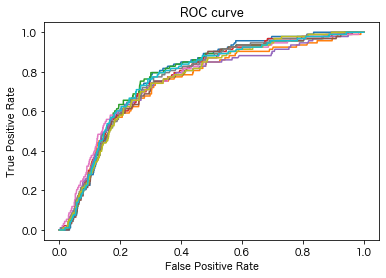

In [6]:
from sklearn import metrics
from sklearn.metrics import roc_curve

ROC_BASE = '../../../data/patient/imputation4/result/roc/{}_{}_{}h'\
    .format(TARGET, CLASSIFIER, HOUR)

def roc(i):
    pp = model[i].predict_proba(X_test[i])[:,1]
    fpr, tpr, threshold = roc_curve(y_test[i].values, pp)

    # save roc data
    df_roc = pd.DataFrame(y_test[i])
    df_roc.columns = ['test']
    df_roc['predict'] = pp
    df_roc.to_csv('{}/roc_{}_{}_{}h_{}.txt'
        .format(ROC_BASE,TARGET, CLASSIFIER, HOUR, i), sep='\t', index=False)

    # AUC
    auc = metrics.auc(fpr, tpr)
    print('AUC=', auc)

    # ROC curve
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    return auc

auc_list = []
for i in range(10):
    auc_list.append(roc(i))

print('AUC 95% CI= {}'.format(np.percentile(auc_list, (2.5, 97.5))))

In [7]:
# get mean
files = glob.glob('{}/*'.format(ROC_BASE))
files.sort()

df_total = pd.DataFrame()
for f in files:
    if f.endswith('_mean.txt'):
        continue
    print(f.split('/')[-1])
    df_ = pd.read_csv(f, sep='\t')
    df_total = pd.concat([df_total, df_], axis=0)

df_mean = df_total.reset_index().groupby('index', as_index=False).mean().drop('index',axis=1)
df_mean.to_csv('{}/roc_{}_{}_{}h_mean.txt'\
    .format(ROC_BASE,TARGET, CLASSIFIER, HOUR), sep='\t', index=False)


roc_dos_more_2w_logistic_24h_0.txt
roc_dos_more_2w_logistic_24h_1.txt
roc_dos_more_2w_logistic_24h_2.txt
roc_dos_more_2w_logistic_24h_3.txt
roc_dos_more_2w_logistic_24h_4.txt
roc_dos_more_2w_logistic_24h_5.txt
roc_dos_more_2w_logistic_24h_6.txt
roc_dos_more_2w_logistic_24h_7.txt
roc_dos_more_2w_logistic_24h_8.txt
roc_dos_more_2w_logistic_24h_9.txt


# get_params

In [14]:
model[1].get_params()

{'C': 1,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 1,
 'solver': 'liblinear',
 'tol': 0.001,
 'verbose': 0,
 'warm_start': True}